# Working with 3rd party (detached) Prompts/Prompt Template Assets(Cloud)



This notebook should be run using with Runtime 22.2 & Python 3.10 or greater runtime environment, if you are viewing this in Watson Studio, and do not see Python 3.10.x in the upper right corner of your screen, please update the runtime now. 

The notebook will create a summarization prompt template asset in a given project, configure OpenScale to monitor that PTA and evaluate generative quality metrics and model health metrics.

If users wish to execute this notebook for task types other than summarization, please consult [this](https://github.com/IBM/watson-openscale-samples/blob/main/IBM%20Cloud/WML/notebooks/watsonx/README.md) document for guidance on evaluating prompt templates for the available task types.

Note : User can search for `EDIT THIS` and fill the inputs needed.

## Prerequisite

* It requires service credentials for IBM Watson OpenScale:
* Requires a CSV file containing the test data that needs to be evaluated
* Requires the ID of project in which you want to create the prompt template asset.

### Contents

- [Setup](#settingup)
- [Create Prompt template](#prompt)
- [Prompt Setup](#ptatsetup)
- [Risk evaluations for prompt template asset subscription](#evaluate)
- [Display the Model Risk metrics](#mrmmetric)
- [Display the Generative AI Quality metrics](#genaimetrics)
- [Plot rougel and rougelsum metrics against records](#plotproject)
- [See factsheets information](#factsheetsspace)

## Setup <a name="settingup"></a>

In [1]:
!pip install --upgrade datasets==2.10.0 --no-cache | tail -n 1
!pip install --upgrade evaluate --no-cache | tail -n 1
!pip install --upgrade ibm-aigov-facts-client | tail -n 1
!pip install --upgrade ibm-watson-openscale | tail -n 1
!pip install --upgrade ibm-watsonx-ai | tail -n 1
!pip install --upgrade matplotlib | tail -n 1
!pip install --upgrade pydantic==1.10.11 --no-cache | tail -n 1
!pip install --upgrade sacrebleu --no-cache | tail -n 1
!pip install --upgrade sacremoses --no-cache | tail -n 1
!pip install --upgrade textstat --no-cache | tail -n 1
!pip install --upgrade transformers --no-cache | tail -n 1

Note: you may need to restart the kernel to use updated packages.

### Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/watson-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [2]:
IAM_URL = "https://iam.cloud.ibm.com"
DATAPLATFORM_URL = "https://api.dataplatform.cloud.ibm.com"
SERVICE_URL = "https://api.aiopenscale.cloud.ibm.com"
CLOUD_API_KEY = "<EDIT THIS>" # YOUR_CLOUD_API_KEY
WML_CREDENTIALS = {
                "url": "https://us-south.ml.cloud.ibm.com",
                "apikey": CLOUD_API_KEY
}

## Set the project ID

In order to set up a development type subscription, the PTA must be within the project. Please supply the project ID where the PTA needs to be created.

In [3]:
PROJECT_ID = "<EDIT THIS>" # YOUR_PROJECT_ID

## Read space id from user

User can use an existing space or can create a new space to promote the model. User should choose any of these options with the below variable.

In [4]:
use_existing_space = True # Set it as False if user wants to create a new space

In [5]:
import json
from ibm_watsonx_ai import APIClient

wml_client = APIClient(WML_CREDENTIALS)
wml_client.version

'1.0.360'

### Below details are required only if user choose to use an existing space

In order to use an existing space, User can directly add the space id in the below cell

In [ ]:
wml_client.spaces.list()

In [10]:
existing_space_id = "a4a76fad-a549-43cd-9d1d-2c17b15f009e" # YOUR_SPACE_ID

### Below details are required only if user choose to create a new space

In [313]:
space_name = "<EDIT THIS>" # YOUR_SPACE_NAME

Tip: `WML_INSTANCE_NAME`, `WML_CRN` and `COS_RESOURCE_CRN` are required only if you are pointing to your cloud openscale instance, Your `WML_INSTANCE_NAME` and `WML_CRN` can be read from the [Cloud console](https://cloud.ibm.com/resources). From that page, goto `Resours list`, Copy the name of your WML instance listed there. Select the row corresponding to your WML instance, and copy the CRN displayed in the popup on the right side of the page

In [314]:
#####################################################################################
# Paste your WML_INSTANCE_NAME, WML CRN in the following field and then run this cell.
######################################################################################
WML_INSTANCE_NAME =  "<EDIT THIS>" # YOUR_WML_INSTANCE_NAME
WML_CRN =  "<EDIT THIS>" # YOUR_WML_CRN

In next cell, you will need to paste COS_RESOURCE_CRN. If you haven't worked with COS yet please visit [getting started with COS tutorial](https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-getting-started-cloud-object-storage).
You can find COS_RESOURCE_CRN variable in Service Credentials in menu of your COS instance.

In [315]:
COS_RESOURCE_CRN = "<EDIT THIS>"

### Setting up the space

In [11]:
if use_existing_space == True:
    space_id = existing_space_id
else:
    space_meta_data = {
        wml_client.spaces.ConfigurationMetaNames.NAME: space_name,
        wml_client.spaces.ConfigurationMetaNames.STORAGE: {"resource_crn":COS_RESOURCE_CRN},
        wml_client.spaces.ConfigurationMetaNames.COMPUTE: {"name": WML_INSTANCE_NAME, "crn": WML_CRN},
        wml_client.spaces.ConfigurationMetaNames.TYPE: "wx"
    }
    space_id = wml_client.spaces.store(
        meta_props=space_meta_data)["metadata"]["id"]
wml_client.set.default_space(space_id)
print(space_id)

a4a76fad-a549-43cd-9d1d-2c17b15f009e


## Function to create the access token

This function generates an IAM access token using the provided credentials. The API calls for creating and scoring prompt template assets utilize the token generated by this function.

In [12]:
import requests, json
def generate_access_token():
    headers={}
    headers["Content-Type"] = "application/x-www-form-urlencoded"
    headers["Accept"] = "application/json"
    data = {
        "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
        "apikey": CLOUD_API_KEY,
        "response_type": "cloud_iam"
    }
    response = requests.post(IAM_URL + "/identity/token", data=data, headers=headers)
    json_data = response.json()
    iam_access_token = json_data["access_token"]
    return iam_access_token

iam_access_token = generate_access_token()

# HuggingFace model

In [13]:
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    model="google/flan-t5-base",
    tokenizer="google/flan-t5-base"
)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [14]:
# Download summarisation data
!rm summarisation.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/summarization/summarisation.csv

rm: cannot remove 'summarisation.csv': No such file or directory
--2024-08-08 15:25:10--  https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/summarization/summarisation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27115 (26K) [text/plain]
Saving to: ‘summarisation.csv’

summarisation.csv   100%[===================>]  26.48K  --.-KB/s    in 0.002s  

2024-08-08 15:25:10 (17.1 MB/s) - ‘summarisation.csv’ saved [27115/27115]



In [15]:
import pandas as pd

test_data_path = "summarisation.csv"
llm_data = pd.read_csv(test_data_path)
llm_data.head()

,doc,id,original_text,reference_summary,title,uid
0,Pokemon GO Terms of Service,57866df76cca83a54c0035a1,by using our services you are agreeing to thes...,by playing this game you agree to these terms....,Agreement To Terms,legalsum02
1,Pokemon GO Terms of Service,5786730a6cca83a54c0035b6,if you want to use certain features of the ser...,you have to use google pokemon trainer club or...,Eligibility and Account Registration,legalsum03
2,Pokemon GO Terms of Service,57866df76cca83a54c0035a0,during game play please be aware of your surro...,don t die or hurt others and if you do it s no...,Safe Play,legalsum04
3,Pokemon GO Terms of Service,57866df76cca83a54c00359f,subject to your compliance with these terms ni...,don t copy modify resell distribute or reverse...,Rights in App,legalsum05
4,Pokemon GO Terms of Service,57866df76cca83a54c00359e,for purposes of these terms a content means th...,we grant you full ownership of your user conte...,Content and Content Rights,legalsum06


## Set the generated_summary with the summary from HF Google Flan model prompt evaluation

In [16]:
def get_completion(prompt_text):
    summary = (summarizer(prompt_text, max_length=len(prompt_text), min_length=1))
    summary_text = summary[0]["summary_text"]
    return summary_text

llm_data["generated_text"] = llm_data["original_text"].apply(get_completion)
llm_data.head()

Your max_length is set to 450, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Token indices sequence length is longer than the specified maximum sequence length for this model (705 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 3180, but your input_length is only 705. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=352)
Your max_length is set to 1935, but your input_length is only 387. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=193)
Your max_length is set to 3721, but your input_length is only 75

,doc,id,original_text,reference_summary,title,uid,generated_text
0,Pokemon GO Terms of Service,57866df76cca83a54c0035a1,by using our services you are agreeing to thes...,by playing this game you agree to these terms....,Agreement To Terms,legalsum02,Use our services if you are the parent or lega...
1,Pokemon GO Terms of Service,5786730a6cca83a54c0035b6,if you want to use certain features of the ser...,you have to use google pokemon trainer club or...,Eligibility and Account Registration,legalsum03,Create an account with us. Register for an acc...
2,Pokemon GO Terms of Service,57866df76cca83a54c0035a0,during game play please be aware of your surro...,don t die or hurt others and if you do it s no...,Safe Play,legalsum04,Be aware of your surroundings
3,Pokemon GO Terms of Service,57866df76cca83a54c00359f,subject to your compliance with these terms ni...,don t copy modify resell distribute or reverse...,Rights in App,legalsum05,niantic grants you a limited nonexclusive nont...
4,Pokemon GO Terms of Service,57866df76cca83a54c00359e,for purposes of these terms a content means th...,we grant you full ownership of your user conte...,Content and Content Rights,legalsum06,niniantic grants you a personal noncommercial ...


# Create Prompt template <a name="prompt"></a>

Create a prompt template for a summarization task

In [17]:
from ibm_aigov_facts_client import AIGovFactsClient

facts_client = AIGovFactsClient(
    api_key=CLOUD_API_KEY,
    container_id=PROJECT_ID,
    container_type="project",
    disable_tracing=True
)

In [18]:
from ibm_aigov_facts_client import DetachedPromptTemplate, PromptTemplate

detached_information = DetachedPromptTemplate(
    prompt_id="detached_prompt",
    model_id="google/flan-t5-base",
    model_provider="Hugging Face",
    model_name="google/flan-t5-base",
    model_url="https://huggingface.co/google/flan-t5-base",
    prompt_url="prompt_url",
    prompt_additional_info={"model_owner": "huggingface"}
)

task_id = "summarization"
name = "External prompt sample (google/flan-t5-base HF) V2.0"
description = "My first detached prompt"
model_id = "google/flan-t5-base"

# define parameters for PromptTemplate
prompt_variables = {"original_text": ""}
input = "{original_text}"
input_prefix= "Input:"
output_prefix= "Output:"

prompt_template = PromptTemplate(
    input=input,
    prompt_variables=prompt_variables,
    input_prefix=input_prefix,
    output_prefix=output_prefix
)

pta_details = facts_client.assets.create_detached_prompt(
    model_id=model_id,
    task_id=task_id,
    name=name,
    description=description,
    prompt_details=prompt_template,
    detached_information=detached_information
)
project_pta_id = pta_details.to_dict()["asset_id"]

2024/08/08 15:28:37 INFO : ------------------------------ Detached Prompt Creation Started ------------------------------
2024/08/08 15:28:38 INFO : The detached prompt with ID 9fc810be-8a65-41af-8d31-cb89096bec63 was created successfully in container_id 1bed2bf0-2a16-4ee5-a017-347939fb4456.


# Prompt setup <a name="ptatsetup"></a>

### Configure OpenScale

In [19]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator, CloudPakForDataAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

service_instance_id = None # Update this to refer to a particular service instance
authenticator = IAMAuthenticator(
    apikey=CLOUD_API_KEY,
    url=IAM_URL
)
wos_client = APIClient(
    authenticator=authenticator,
    service_url=SERVICE_URL,
    service_instance_id=service_instance_id
)
data_mart_id = wos_client.service_instance_id
print(wos_client.version)

3.0.40


### Setup the prompt template asset in project for evaluation with supported monitor dimensions

The prompt template assets from project is only supported with `development` operational space ID. Running the below cell will create a development type subscription from the prompt template asset created within the project.

The available parameters that can be passed for `execute_prompt_setup` function are:

 * `prompt_template_asset_id` : Id of prompt template asset for which subscription needs to be created.
 * `label_column` :  The name of the column containing the ground truth or actual labels.
 * `project_id` : The GUID of the project.
 * `space_id` : The GUID of the space.
 * `deployment_id` :The GUID of the deployment.
 * `operational_space_id` : The rank of the environment in which the monitoring is happening. Accepted values are `development`, `pre_production`, `production`.
 * `problem_type` : (optional) The task type to monitor for the given prompt template asset.
 * `classification_type` : The classification type `binary`/`multiclass` applicable only for `classification` problem (task) type.
 * `input_data_type` : The input data type.
 * `supporting_monitors` : Monitor configuration for the subscription to be created.
 * `background_mode` : When `True`, the promt setup operation will be executed in the background

In [20]:
label_column = "reference_summary"
operational_space_id = "development"
problem_type = "summarization"
input_data_type = "unstructured_text"


monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration": {                    
            }
        }
    }
}

response = wos_client.monitor_instances.mrm.execute_prompt_setup(
    prompt_template_asset_id=project_pta_id, 
    project_id=PROJECT_ID,
    label_column=label_column,
    operational_space_id=operational_space_id, 
    problem_type=problem_type,
    input_data_type=input_data_type, 
    supporting_monitors=monitors, 
    background_mode=False
)

result = response.result
result.to_dict()

This method will be deprecated in the next release and be replaced by wos_client.wos.execute_prompt_setup() method



 Waiting for end of adding prompt setup 9fc810be-8a65-41af-8d31-cb89096bec63 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '9fc810be-8a65-41af-8d31-cb89096bec63',
 'project_id': '1bed2bf0-2a16-4ee5-a017-347939fb4456',
 'deployment_id': '5b2412b4-883d-4379-ba4e-134d32f4ba42',
 'service_provider_id': '1d601d1e-a7b8-4079-b145-21a9b07afa59',
 'subscription_id': '38c9f860-2785-4316-8f43-a4a9490f14da',
 'mrm_monitor_instance_id': '95c026fa-c06e-4f45-99b5-effe8bb16663',
 'start_time': '2024-08-08T15:28:44.519464Z',
 'end_time': '2024-08-08T15:28:56.235521Z',
 'status': {'state': 'FINISHED'}}

With the below cell, users can  read the  prompt setup task and check its status

In [21]:
response = wos_client.monitor_instances.mrm.get_prompt_setup(
    prompt_template_asset_id=project_pta_id,
    project_id=PROJECT_ID
)

result = response.result
result_json = result.to_dict()

if result_json["status"]["state"] == "FINISHED":
    print("Finished prompt setup. The response is {}".format(result_json))
else:
    print("Prompt setup failed. The response is {}".format(result_json))

This method will be deprecated in the next release and be replaced by wos_client.wos.get_prompt_setup() method
Finished prompt setup. The response is {'prompt_template_asset_id': '9fc810be-8a65-41af-8d31-cb89096bec63', 'project_id': '1bed2bf0-2a16-4ee5-a017-347939fb4456', 'deployment_id': '5b2412b4-883d-4379-ba4e-134d32f4ba42', 'service_provider_id': '1d601d1e-a7b8-4079-b145-21a9b07afa59', 'subscription_id': '38c9f860-2785-4316-8f43-a4a9490f14da', 'mrm_monitor_instance_id': '95c026fa-c06e-4f45-99b5-effe8bb16663', 'start_time': '2024-08-08T15:28:44.519464Z', 'end_time': '2024-08-08T15:28:56.235521Z', 'status': {'state': 'FINISHED'}}


### Read required IDs from prompt setup response

In [22]:
subscription_id = result_json["subscription_id"]
mrm_monitor_instance_id = result_json["mrm_monitor_instance_id"]

## Show all the monitor instances of the production subscription
The following cell lists the monitors present in the development subscription along with their respective statuses and other details. Please wait for all the monitors to be in active state before proceeding further.

In [23]:
wos_client.monitor_instances.show(target_target_id=subscription_id)

4761e11b-18ab-4e88-a79d-b0e26609af5f,active,38c9f860-2785-4316-8f43-a4a9490f14da,subscription,generative_ai_quality,2024-08-08 15:28:49.281000+00:00,f7901cc3-0171-4d55-8c9b-4f0a27af59e6
4761e11b-18ab-4e88-a79d-b0e26609af5f,active,38c9f860-2785-4316-8f43-a4a9490f14da,subscription,model_health,2024-08-08 15:28:50.030000+00:00,2fe3312f-429f-42a4-b5ad-cfa0054ddf58
4761e11b-18ab-4e88-a79d-b0e26609af5f,active,38c9f860-2785-4316-8f43-a4a9490f14da,subscription,mrm,2024-08-08 15:28:51.194000+00:00,95c026fa-c06e-4f45-99b5-effe8bb16663


# Risk evaluations for PTA subscription <a name="evaluate"></a>

### Evaluate the prompt template subscription

For the risk assessment of a development type subscription the user needs to have an evaluation dataset. The risk evaluation function takes the evaluation dataset path as a parameter for evaluation of the configured metric dimensions. If there is a discrepancy between the feature columns in the subscription and the column names in the uploading CSV, users has the option to supply a mapping JSON file to associate the CSV column names with the feature column names in the subscription.


**Note:* If you are running this notebook from Watson studio, you may first need to upload your test data to studio and run code snippet to download feedback data file from project to local directory

The following cell will assess the test data with the subscription of the prompt template asset and produce relevant measurements for the configured monitor.

In [55]:
test_data_set_name = "data"
content_type = "multipart/form-data"
body = {}
# Preparing the test data, removing extra columns
cols_to_remove = ["uid", "doc", "title", "id"]
for col in cols_to_remove:
    if col in llm_data:
        del llm_data[col]
llm_data.to_csv(test_data_path, index=False)

response  = wos_client.monitor_instances.mrm.evaluate_risk(
    monitor_instance_id=mrm_monitor_instance_id,
    test_data_set_name=test_data_set_name, 
    test_data_path=test_data_path,
    content_type=content_type,
    body=body,
    project_id=PROJECT_ID,
    includes_model_output=True,
    background_mode=False
)




 Waiting for risk evaluation of MRM monitor 95c026fa-c06e-4f45-99b5-effe8bb16663 




upload_in_progress
running...
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results are now available for review

In [56]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_instance_id, project_id=PROJECT_ID)
response.result.to_dict()

{'metadata': {'id': '9061d9c6-8c33-484d-aee7-20f955ced4c0',
  'created_at': '2024-08-08T15:42:22.581Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'evaluation_start_time': '2024-08-08T15:42:13.597597Z',
   'evaluator_user_key': 'a02e6eb2-31c9-49e1-b1ca-196824fdae8b',
   'facts': {'state': 'finished'},
   'is_auto_evaluated': False,
   'measurement_id': '77a99849-838f-4a19-9848-5c999b536005',
   'project_id': '1bed2bf0-2a16-4ee5-a017-347939fb4456',
   'prompt_template_asset_id': '9fc810be-8a65-41af-8d31-cb89096bec63',
   'user_iam_id': 'IBMid-694000BNQ7',
   'wos_created_deployment_id': '5b2412b4-883d-4379-ba4e-134d32f4ba42',
   'publish_metrics': 'false',
   'evaluation_tests': ['drift_v2',
    'generative_ai_quality',
    'model_health',
    'quality']},
  'status': {'state': 'finished',
   'queued_at': '2024-08-08T15:42:22.564000Z',
   'started_at': '2024-08-08T15:42:23.065000Z',
   'updated_at': '2024-0

# Display the Model Risk metrics <a name="mrmmetric"></a>

Having calculated the measurements for the Foundation Model subscription, the MRM metrics generated for this subscription are now available for your review.

In [57]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_instance_id, project_id=PROJECT_ID)

2024-08-08 15:42:22.646000+00:00,tests_passed,77a99849-838f-4a19-9848-5c999b536005,1.0,None,None,['test_data_set_name:data'],mrm,95c026fa-c06e-4f45-99b5-effe8bb16663,9061d9c6-8c33-484d-aee7-20f955ced4c0,subscription,38c9f860-2785-4316-8f43-a4a9490f14da
2024-08-08 15:42:22.646000+00:00,tests_run,77a99849-838f-4a19-9848-5c999b536005,1.0,None,None,['test_data_set_name:data'],mrm,95c026fa-c06e-4f45-99b5-effe8bb16663,9061d9c6-8c33-484d-aee7-20f955ced4c0,subscription,38c9f860-2785-4316-8f43-a4a9490f14da
2024-08-08 15:42:22.646000+00:00,tests_skipped,77a99849-838f-4a19-9848-5c999b536005,2.0,None,None,['test_data_set_name:data'],mrm,95c026fa-c06e-4f45-99b5-effe8bb16663,9061d9c6-8c33-484d-aee7-20f955ced4c0,subscription,38c9f860-2785-4316-8f43-a4a9490f14da
2024-08-08 15:42:22.646000+00:00,tests_failed,77a99849-838f-4a19-9848-5c999b536005,0.0,None,None,['test_data_set_name:data'],mrm,95c026fa-c06e-4f45-99b5-effe8bb16663,9061d9c6-8c33-484d-aee7-20f955ced4c0,subscription,38c9f860-2785-4316-8f43-a4a9490f14da


# Display the Generative AI Quality metrics <a name="genaimetrics"></a>



Monitor instance ID of Generative ai quality metrics is required for reading its metrics.

In [58]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=subscription_id,
    project_id=PROJECT_ID
).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'f7901cc3-0171-4d55-8c9b-4f0a27af59e6'

Displaying the GenAIQ monitor metrics generated through the risk evaluation.

In [ ]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, project_id=PROJECT_ID)

## Display record level metrics for Generative AI Quality 

Read the dataset id for generative ai quality dataset

In [60]:
result = wos_client.data_sets.list(
    target_target_id=subscription_id,
    target_target_type="subscription",
    type="gen_ai_quality_metrics"
).result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'32c72a80-05de-48ac-b9d5-2cb823f0a621'

Displaying record level metrics for generative ai quality

In [ ]:
wos_client.data_sets.show_records(data_set_id=genaiq_dataset_id)

# Plot rougel and rougelsum metrics against records <a name="plotproject"></a>

In [62]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

Plot rougel metrics against records

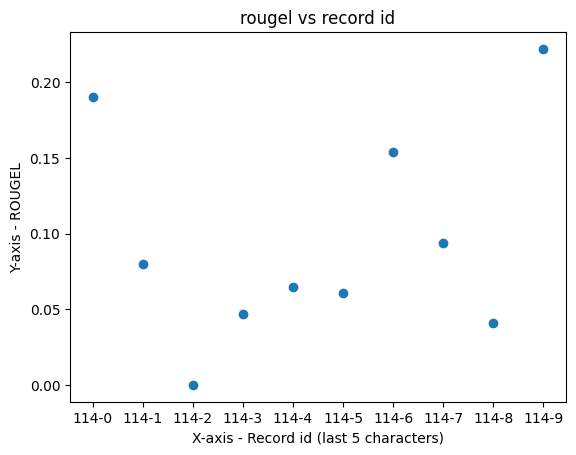

In [63]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel("X-axis - Record id (last 5 characters)")
plt.ylabel("Y-axis - ROUGEL")
plt.title("rougel vs record id")

# Display the graph
plt.show()

Plot rougelsum metrics against records

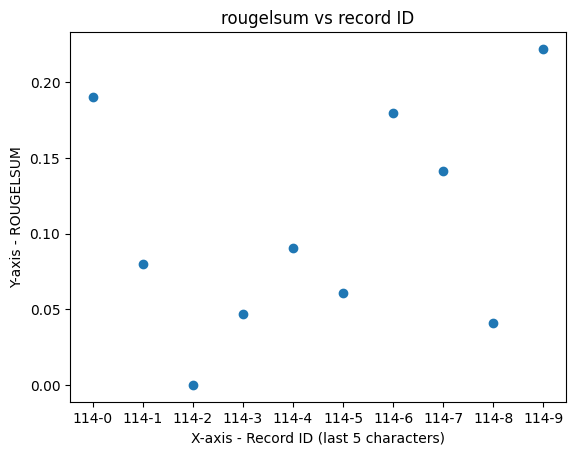

In [64]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougelsum, marker="o")

# Adding labels and title
plt.xlabel("X-axis - Record ID (last 5 characters)")
plt.ylabel("Y-axis - ROUGELSUM")
plt.title("rougelsum vs record ID")

# Display the graph
plt.show()

# See factsheets information <a name="factsheetsspace"></a>

In [65]:
factsheets_url = f"{DATAPLATFORM_URL.replace('api.', '')}/wx/prompt-details/{project_pta_id}/factsheet?context=wx&project_id={PROJECT_ID}"

print(f"User can navigate to the published facts in project {factsheets_url}")

User can navigate to the published facts in project https://dataplatform.cloud.ibm.com/wx/prompt-details/9fc810be-8a65-41af-8d31-cb89096bec63/factsheet?context=wx&project_id=1bed2bf0-2a16-4ee5-a017-347939fb4456


# Evaluate Prompt template from space <a name="evaluatespace"></a>

Now, we can promote the created prompt template asset to space and perform similar actions.

# Promote PTA to space <a name="promottospace"></a> 

Below cell promotes the prompt template asset from the project to the space.

In [35]:
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)
verify = True

url = "{}/v2/assets/{}/promote".format(DATAPLATFORM_URL ,project_pta_id)

params = {
    "project_id":PROJECT_ID
}

payload = {
    "space_id": space_id
}
response = requests.post(url, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()
space_pta_id = json_data["metadata"]["asset_id"]
space_pta_id

'418b136e-15c9-4a74-afed-5f5fa33f1a78'

# Create deployment for prompt template asset in space <a name="ptadeployment"></a>

To create a subscription from space, it is necessary to create a deployment for prompt template assets in spaces.

In [36]:
DEPLOYMENTS_URL = WML_CREDENTIALS["url"] + "/ml/v4/deployments"

# serving_name = "summarization_deployment_detached" # eg: summary_deployment

payload = {
    "prompt_template": {
      "id": space_pta_id
    },
    "detached": {
    },
    "base_model_id": "google/flan-t5-base",
    "description": "summarization deployment",
    "name": "summarization deployment",
    "space_id": space_id
}

version = "2023-07-07" # The version date for the API of the form YYYY-MM-DD. Example : 2023-07-07
params = {
    "version":version,
    "space_id":space_id
}

response = requests.post(DEPLOYMENTS_URL, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()


if "metadata" in json_data:
    deployment_id = json_data["metadata"]["id"]
    print(deployment_id)
else:
    print(json_data)

e0ed7fff-980f-43af-9e94-24b135ed4d68


In [37]:
#     try:
#       wos_client.wos.add_instance_mapping(                
#         service_instance_id=data_mart_id,
#         space_id=existing_space_id,
#       )
#     except ApiRequestFailure as arf:
#        if arf.response.status_code == 409:
#           # Instance mapping already exists
#           pass
#        else:
#           raise arf

# Setup the prompt template asset in space for evaluation with supported monitor dimensions <a name="ptaspace"></a>

The prompt template assets from space is only supported with [`pre_production` and `production`] operational space IDs. Running the below cell will create a `pre_production` type subscription from the prompt template asset promoted to the space. The `problem_type` value should depend on the task type specified in the prompt template asset.

In [38]:
label_column = "reference_summary"
operational_space_id = "pre_production"
problem_type= "summarization"
input_data_type= "unstructured_text"
monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration":{        
            }
        }
    },
#####################################################################################
    #For production flow add and configure the following drift monitor
######################################################################################
    # "drift_v2": {
    #     "thresholds": [
    #         {
    #             "metric_id": "confidence_drift_score",
    #             "type": "upper_limit",
    #             "value": 0.05
    #         },
    #         {
    #             "metric_id": "prediction_drift_score",
    #             "type": "upper_limit",
    #             "value": 0.05
    #         },
    #         {
    #             "metric_id": "input_metadata_drift_score",
    #             "specific_values": [
    #                 {
    #                     "applies_to": [
    #                         {
    #                             "type": "tag",
    #                             "value": "subscription",
    #                             "key": "field_type"
    #                         }
    #                     ],
    #                     "value": 0.05
    #                 }
    #             ],
    #             "type": "upper_limit"
    #         },
    #         {
    #             "metric_id": "output_metadata_drift_score",
    #             "specific_values": [
    #                 {
    #                     "applies_to": [
    #                         {
    #                             "type": "tag",
    #                             "value": "subscription",
    #                             "key": "field_type"
    #                         }
    #                     ],
    #                     "value": 0.05
    #                 }
    #             ],
    #             "type": "upper_limit"
    #         }
    #     ],
    #     "parameters": {
    #         "min_samples": 10,
    #         "train_archive": True
    #     }
    # }
}


response = wos_client.monitor_instances.mrm.execute_prompt_setup(prompt_template_asset_id = space_pta_id, 
                                                                   space_id = space_id,
                                                                   deployment_id = deployment_id,
                                                                   label_column = label_column, 
                                                                   operational_space_id = operational_space_id, 
                                                                   problem_type = problem_type,
                                                                   input_data_type = input_data_type, 
                                                                   supporting_monitors = monitors, 
                                                                   background_mode = False)

result = response.result
result._to_dict()

This method will be deprecated in the next release and be replaced by wos_client.wos.execute_prompt_setup() method



 Waiting for end of adding prompt setup 418b136e-15c9-4a74-afed-5f5fa33f1a78 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '418b136e-15c9-4a74-afed-5f5fa33f1a78',
 'space_id': 'a4a76fad-a549-43cd-9d1d-2c17b15f009e',
 'deployment_id': 'e0ed7fff-980f-43af-9e94-24b135ed4d68',
 'service_provider_id': 'd7f990e5-5547-4dd7-8b68-9760dc6682b8',
 'subscription_id': '3e1d1892-eb57-40d7-8269-577285ed1b01',
 'mrm_monitor_instance_id': '1a1aa726-1bec-41b3-9fd8-0ab57f890f46',
 'start_time': '2024-08-08T15:30:15.228918Z',
 'end_time': '2024-08-08T15:30:29.914000Z',
 'status': {'state': 'FINISHED'}}

With the below cell, users can read the prompt setup task and check its status

In [39]:
response = wos_client.monitor_instances.mrm.get_prompt_setup(prompt_template_asset_id = space_pta_id,
                                                             deployment_id = deployment_id,
                                                             space_id = space_id)

result = response.result
result_json = result._to_dict()
result_json

This method will be deprecated in the next release and be replaced by wos_client.wos.get_prompt_setup() method


{'prompt_template_asset_id': '418b136e-15c9-4a74-afed-5f5fa33f1a78',
 'space_id': 'a4a76fad-a549-43cd-9d1d-2c17b15f009e',
 'deployment_id': 'e0ed7fff-980f-43af-9e94-24b135ed4d68',
 'service_provider_id': 'd7f990e5-5547-4dd7-8b68-9760dc6682b8',
 'subscription_id': '3e1d1892-eb57-40d7-8269-577285ed1b01',
 'mrm_monitor_instance_id': '1a1aa726-1bec-41b3-9fd8-0ab57f890f46',
 'start_time': '2024-08-08T15:30:15.228918Z',
 'end_time': '2024-08-08T15:30:29.914000Z',
 'status': {'state': 'FINISHED'}}

### Read subscription id from prompt setup

Once prompt setup status is finished, Read the subscription id from it.

In [40]:
prod_subscription_id = result_json["subscription_id"]
prod_subscription_id

'3e1d1892-eb57-40d7-8269-577285ed1b01'

## Below segment is required only if the user chooses PRODUCTION SPACE <a name="Prod"></a>

Now that the WML service has been bound and the subscription has been created, we need to score the prompt template asset. The downloaded csv is used to construct the payload as well as feedback for the deployment.

In [389]:
import csv

feature_fields = ["original_text"]
prediction = "generated_text"

pl_data = []
prediction_list = []

with open(test_data_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        request = {
            "parameters": {
                "template_variables": {
                }
            }
        }
        for each in feature_fields:
            request["parameters"]["template_variables"][each] = str(row[each])

        predicted_val = row[prediction]
        prediction_list.append(predicted_val)
        response = {
            "results": [
                {
                    prediction: predicted_val
                }
            ]
        }
        record = {"request": request, "response": response}
        pl_data.append(record)
pl_data

[{'request': {'parameters': {'template_variables': {'original_text': 'by using our services you are agreeing to these terms our trainer guidelines and our privacy policy. if you are the parent or legal guardian of a child under the age of 13 the parent you are agreeing to these terms on behalf of yourself and your child ren who are authorized to use the services pursuant to these terms and in our privacy policy. if you don t agree to these terms our trainer guidelines and our privacy policy do not use the services.'}}},
  'response': {'results': [{'generated_text': 'Use our services if you are the parent or legal guardian of a child under the age of 13'}]}},
 {'request': {'parameters': {'template_variables': {'original_text': 'if you want to use certain features of the services you will have to create an account with us an account. you can create an account if you have a a pre existing google account b a pre existing pok\\u00e9mon trainer club ptc account c a pre existing account with 

### Generating additional payload data to enable drift(`Prod` only)

To enable drift there should be minimum 100 records in the payload table. The below cell duplicates the scored records and create another 100 records for adding to the payload table

In [390]:
additional_pl_data = copy.copy(pl_data)
additional_pl_data *= 11
print("Generated {} additional payload data".format(len(additional_pl_data)))

Generated 110 additional payload data


### Adding payload data

Below cell reads the payload data set id from the subscription. 

In [391]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=prod_subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  f63b482c-1c50-481d-9895-7470c0a63dbe


Add additioanl payload data to enable drift V2

In [392]:
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=pl_data,background_mode=False)
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))




 Waiting for end of storing records with request id: 1f19d0dd-7414-4b38-9be3-f72f87c62107 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 10


Now a total of 110 records should be available within the payload table. But in case if auto payload logging fails to transmit the scored records to the payload logging table, the following code can be used to manually add payload data to the table.

In [393]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))
if pl_records_count < 110:
    print("Payload logging did not happen, performing explicit payload logging.")
    wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=pl_data,background_mode=False)
    time.sleep(5)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))

Number of records in the payload logging table: 10
Payload logging did not happen, performing explicit payload logging.



 Waiting for end of storing records with request id: b1a7d54e-bab5-4b7c-b8c5-c5a0e6c385d7 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 20


### Adding feedback data

Below cell reads the feedback data set id from the subscription. 

In [394]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
feedback_data_set_id = None
feedback_data_set_id = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=prod_subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if feedback_data_set_id is None:
    print("Feedback data set not found. Please check subscription status.")
else:
    print("Feedback data set id: ", feedback_data_set_id)

Feedback data set id:  1e624254-5e4d-459d-bdcc-4118b202d804


The provided code generates feedback data based on the downloaded CSV file and the scored response.

In [ ]:

test_data_content = []
prediction_list = llm_data["generated_text"].tolist()

for _, row in llm_data.iterrows():
    # Read each row from the DataFrame and add label and prediction values
    result_row = [row[key] for key in feature_fields if key in row]
    result_row.append(row[label_column])
    result_row.append(row["generated_text"])
    test_data_content.append(result_row)

if len(test_data_content) == 10: # 10 records are there in the downloaded CSV
    print("generated feedback data from DataFrame")
else:
    print("Failed to generate feedback data from DataFrame, kindly verify the DataFrame content")

fields = feature_fields.copy()
fields.append(label_column)
fields.append("_original_prediction")
feedback_data = [
    {
        "fields": fields,
        "values": test_data_content
    }
]

feedback_data

The following code can be used to manually add feedback data to the table.

In [396]:
wos_client.data_sets.store_records(data_set_id=feedback_data_set_id, request_body=feedback_data,background_mode=False)
time.sleep(5)
fb_records_count = wos_client.data_sets.get_records_count(feedback_data_set_id)
time.sleep(10)
print("Number of records in the feedback logging table: {}".format(fb_records_count))




 Waiting for end of storing records with request id: ba224960-66a1-4004-9ac7-bd0c14e2643e 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the feedback logging table: 10


## Show all the monitor instances of the subscription
The following cell lists the monitors present in the `pre_production`/`production` subscription along with their respective statuses and other details. Please wait for all the monitors to be in active state before proceeding further.

In [42]:
import time
time.sleep(10)
wos_client.monitor_instances.show(target_target_id = prod_subscription_id)

4761e11b-18ab-4e88-a79d-b0e26609af5f,active,3e1d1892-eb57-40d7-8269-577285ed1b01,subscription,generative_ai_quality,2024-08-08 15:30:20.529000+00:00,75ea9294-3034-4065-836e-9ee41becc0fe
4761e11b-18ab-4e88-a79d-b0e26609af5f,active,3e1d1892-eb57-40d7-8269-577285ed1b01,subscription,model_health,2024-08-08 15:30:21.540000+00:00,18d9ee91-8047-4201-9765-2021912592c8
4761e11b-18ab-4e88-a79d-b0e26609af5f,active,3e1d1892-eb57-40d7-8269-577285ed1b01,subscription,mrm,2024-08-08 15:30:22.482000+00:00,1a1aa726-1bec-41b3-9fd8-0ab57f890f46


### Read the MRM monitor instance ID of PTA subscription deployed in space

Evaluating the test data against the prompt template subscription requires the monitor instance ID of MRM.

In [43]:
monitor_definition_id = "mrm"
target_target_id = prod_subscription_id
result = wos_client.monitor_instances.list(data_mart_id=data_mart_id,
                                           monitor_definition_id=monitor_definition_id,
                                           target_target_id=target_target_id,
                                           space_id=space_id).result
result_json = result._to_dict()
mrm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mrm_monitor_id

'1a1aa726-1bec-41b3-9fd8-0ab57f890f46'

### Evaluate the prompt template subscription from space

The following cell will assess subscription of the prompt template asset and produce relevant measurements for the configured monitor. The data to be evaluated are already uploaded to payload and feedback table.

In [ ]:
#####################################################################################
        #For production flow 
######################################################################################
# response  = wos_client.monitor_instances.mrm.evaluate_risk(monitor_instance_id=mrm_monitor_id, 
#                                                     body = body,
#                                                     space_id = space_id,
#                                                     evaluation_tests = ["generative_ai_quality", "model_health"],
#                                                     background_mode = False)

In [44]:
#####################################################################################
        #For pre_production flow 
######################################################################################
response  = wos_client.monitor_instances.mrm.evaluate_risk(
                                                    monitor_instance_id=mrm_monitor_id,
                                                    body=body, 
                                                    test_data_set_name=test_data_set_name,
                                                    test_data_path=test_data_path,        
                                                    content_type=content_type,            
                                                    includes_model_output=True,           
                                                    space_id = existing_space_id,
                                                    background_mode = False
                                                    )




 Waiting for risk evaluation of MRM monitor 1a1aa726-1bec-41b3-9fd8-0ab57f890f46 




upload_in_progress.
running...
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results of PTA from space are now available for review,

In [45]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_id, space_id = space_id)
response.result.to_dict()

{'metadata': {'id': '5841a1a0-338e-4ffa-8050-439b9f12ae42',
  'created_at': '2024-08-08T15:31:28.709Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'deployment_id': 'e0ed7fff-980f-43af-9e94-24b135ed4d68',
   'evaluation_start_time': '2024-08-08T15:31:15.690765Z',
   'evaluator_user_key': '50c17ae9-7eb8-4129-b676-8a0a3c315585',
   'facts': {'state': 'finished'},
   'is_auto_evaluated': False,
   'measurement_id': '36a8db24-ddca-413b-a652-ceb611185a97',
   'prompt_template_asset_id': '418b136e-15c9-4a74-afed-5f5fa33f1a78',
   'prompt_template_details': {'pta_resource_key': '18632eeed522a39c2cb3e6b9fd34b20e71df0e9c811666c51355777ceb11004a'},
   'space_id': 'a4a76fad-a549-43cd-9d1d-2c17b15f009e',
   'user_iam_id': 'IBMid-694000BNQ7',
   'publish_metrics': 'false',
   'evaluation_tests': ['drift_v2',
    'generative_ai_quality',
    'model_health',
    'quality']},
  'status': {'state': 'finished',
   'queued_at

## Display the Model Risk metrics

Having calculated the measurements for the Foundation Model subscription, the MRM metrics generated for this subscription are now available for your review.

In [46]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_id, space_id=space_id)

2024-08-08 15:31:29.107000+00:00,tests_passed,36a8db24-ddca-413b-a652-ceb611185a97,1.0,None,None,['test_data_set_name:data'],mrm,1a1aa726-1bec-41b3-9fd8-0ab57f890f46,5841a1a0-338e-4ffa-8050-439b9f12ae42,subscription,3e1d1892-eb57-40d7-8269-577285ed1b01
2024-08-08 15:31:29.107000+00:00,tests_run,36a8db24-ddca-413b-a652-ceb611185a97,1.0,None,None,['test_data_set_name:data'],mrm,1a1aa726-1bec-41b3-9fd8-0ab57f890f46,5841a1a0-338e-4ffa-8050-439b9f12ae42,subscription,3e1d1892-eb57-40d7-8269-577285ed1b01
2024-08-08 15:31:29.107000+00:00,tests_skipped,36a8db24-ddca-413b-a652-ceb611185a97,2.0,None,None,['test_data_set_name:data'],mrm,1a1aa726-1bec-41b3-9fd8-0ab57f890f46,5841a1a0-338e-4ffa-8050-439b9f12ae42,subscription,3e1d1892-eb57-40d7-8269-577285ed1b01
2024-08-08 15:31:29.107000+00:00,tests_failed,36a8db24-ddca-413b-a652-ceb611185a97,0.0,None,None,['test_data_set_name:data'],mrm,1a1aa726-1bec-41b3-9fd8-0ab57f890f46,5841a1a0-338e-4ffa-8050-439b9f12ae42,subscription,3e1d1892-eb57-40d7-8269-577285ed1b01


## Display the Generative AI Quality metrics

### Read the Generative ai quality monitor instance id

Monitor instance ID of Generative ai quality metrics is required for reading its metrics.

In [47]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           space_id = space_id).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'75ea9294-3034-4065-836e-9ee41becc0fe'

Displaying the monitor metrics of GenAIQ generated through the risk evaluation.

In [ ]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, space_id=space_id)

## Display record level metrics for Generative AI Quality 

Read the dataset id for generative ai quality dataset

In [49]:
result = wos_client.data_sets.list(target_target_id = prod_subscription_id,
                                target_target_type = "subscription",
                                type = "gen_ai_quality_metrics").result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'918f8a9e-ec1a-4469-8fe5-f7d435959a7c'

Displaying record level metrics for generative ai quality

In [ ]:
wos_client.data_sets.show_records(data_set_id = genaiq_dataset_id)

# Plot rougel and rougelsum metrics against records <a name="plotspace"></a>

In [51]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

Plot rougel metrics against records

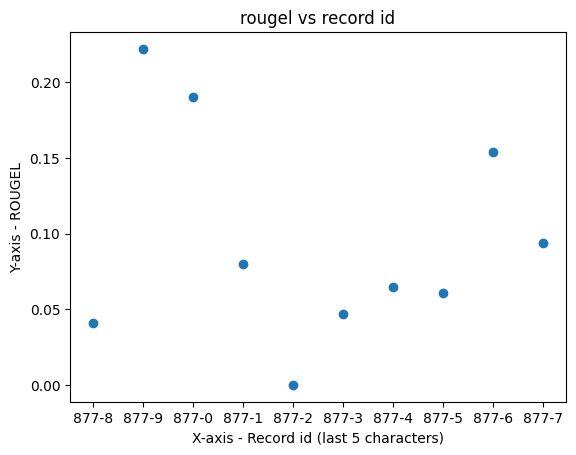

In [52]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGEL')
plt.title('rougel vs record id')

# Display the graph
plt.show()

Plot rougelsum metrics against records

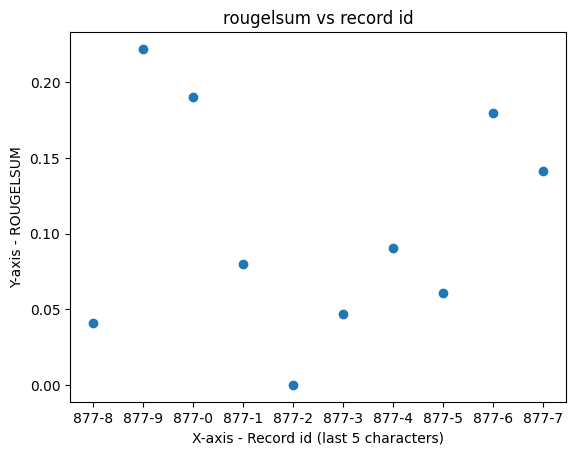

In [53]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougelsum, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGELSUM')
plt.title('rougelsum vs record id')

# Display the graph
plt.show()

## Display the Drift V2 metrics (`Prod` only)

### Read the Drift V2 monitor instance id

Monitor instance ID of Drift V2 metrics is required for reading its metrics.

In [ ]:
monitor_definition_id = "drift_v2"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           space_id = space_id).result
result_json = result._to_dict()
drift_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
drift_monitor_id

Displaying the monitor metrics of Drift V2 generated through the risk evaluation.

In [ ]:
time.sleep(15)
wos_client.monitor_instances.show_metrics(monitor_instance_id=drift_monitor_id, space_id=space_id)

# User can navigate to see the published facts in space <a name="factsheetsproject"></a>

In [54]:
factsheets_url = "https://dataplatform.cloud.ibm.com/ml-runtime/deployments/{}/details?space_id={}&context=wx&flush=true".format(deployment_id, space_id)
print("User can navigate to the published facts in space {}".format(factsheets_url))

User can navigate to the published facts in space https://dataplatform.cloud.ibm.com/ml-runtime/deployments/e0ed7fff-980f-43af-9e94-24b135ed4d68/details?space_id=a4a76fad-a549-43cd-9d1d-2c17b15f009e&context=wx&flush=true


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now navigate to the prompt template asset in your project / spaceand click on the Evaluate tab to visualise the results on the UI.